In [1]:
#importing model
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

#importing neccesary packages
from PIL import Image, ImageChops
import requests
import torch
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.morphology import dilation, disk
import cv2
from scipy import ndimage

/var/home/daniel/micromamba/envs/mambaenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-24 00:10:39.650243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#importing data from cached patches folder

def data_transform(data):
    data = data - np.min(data)
    data = np.round(data * 255/np.max(data))
    data = data.astype(np.uint8)
    return np.array(data)

def train_patches(directory):
    transformed_data_list = []
    targets = []
    non_targets = []
    density = []
    transformed_data_list_eval = []
    targets_eval = []
    non_targets_eval = []
    density_eval = []

    print('Retrieving training data:')
    for i in tqdm(range(10)):  # Range from 0 to 3565 for train samples
        filename = f"train_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets.append(nontargets1)

                density1 = data0['density'].numpy()
                density.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    print('Retrieving validation data:')
    for i in tqdm(range(10)):  # Range from 0 to 787 for val samples
        filename = f"val_{i}.pt"
        file_path = os.path.join(directory, filename)
        if os.path.exists(file_path):
            try:
                data0 = torch.load(file_path)
                data1 = data0['aerial_20'].numpy()
                data1 = data1.transpose()
                transformed_data = data_transform(data1)
                transformed_data_list_eval.append(transformed_data)
                
                target1 = data0['target'].numpy()
                targets_eval.append(target1)
                
                nontargets1 = data0['target_mask'].numpy() - target1
                non_targets_eval.append(nontargets1)

                density1 = data0['density'].numpy()
                density_eval.append(density1)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return (transformed_data_list, targets, non_targets, density, 
            transformed_data_list_eval, targets_eval, non_targets_eval, density_eval)

data, targets, non_targets, density, data_eval, targets_eval, non_targets_eval, density_eval = train_patches('patches')

print('Total train patches retrived:',len(data))
print('Total evaluation patches retrived:',len(data_eval))

Retrieving training data:


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


Retrieving validation data:


100%|██████████| 10/10 [00:00<00:00, 23.23it/s]

Total train patches retrived: 10
Total evaluation patches retrived: 10


In [6]:
def combine_masks_average_overlap(masks):
        # Create an array to count the number of non-zero entries for each pixel
        count_non_zero = np.zeros_like(masks[0], dtype=np.float32)

        # Create an array to sum the probabilities for each pixel
        sum_probabilities = np.zeros_like(masks[0], dtype=np.float32)

        for mask in masks:
            mask = np.array(mask)
            # Update the count of non-zero entries
            count_non_zero += (mask > 0)

            # Add the probabilities to the sum (this includes zeros)
            sum_probabilities += mask

        # To avoid division by zero, we set the count to 1 for pixels where it's zero
        count_non_zero[count_non_zero == 0] = 1

        # Compute the average only for overlapping areas
        combined_mask = sum_probabilities / count_non_zero

        return combined_mask

In [29]:

def mask2former_visulization(data):
    data1 = data[0:10]
    fig, ax = plt.subplots(2, 5, figsize=(30, 10))
    for i, image_array in enumerate(data1):
        maps = []
        comb_true = False

        image = Image.fromarray((image_array * 255).astype(np.uint8))
        inputs = image_processor(image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)

        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

        masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
        masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)


        for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
            mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
            mask[mask < 0.5] = 0

            if np.max(targets[i])==0:
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    binary_mask = mask.numpy() > 0.4

                    if np.sum(binary_mask) == 0:
                        continue

                    # Calculate the center of mass of the binary mask
                    center_of_mass = ndimage.center_of_mass(binary_mask)
                    
                    indices = np.where(binary_mask)
                    
                    min_y, max_y = np.min(indices[0]), np.max(indices[0])
                    min_x, max_x = np.min(indices[1]), np.max(indices[1])
                    
                    # Check if all values above the threshold are within a 60-pixel radius of the center of mass
                    if (max_y - min_y <= 120) and (max_x - min_x <= 120):
                        maps.append(mask)
                continue

            # Create a binary mask for the target
            binary_target = np.where(targets[i].transpose() == 1, 1, 0).astype(np.uint8)

            # Use a smaller structuring element for faster operation
            selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))

            # Perform dilation
            dilated_target = cv2.dilate(binary_target, selem)

            # Check if the entirety of the mask is within the dilated target
            if np.array_equal(mask * dilated_target, mask):
                # Check if any part of the mask overlaps with the target
                if torch.sum(mask * targets[i].transpose()) > 0:
                    # Check if none of the mask overlaps with the non-target
                    if torch.sum(mask * non_targets[i].transpose()) == 0:
                        maps.append(mask)

        if np.shape(maps)[0] != 0:
            combined_mask = combine_masks_average_overlap(maps)
            comb_true = True

        ax[int(i > 4), i%5].imshow(data[i])

        if np.sum(targets[i]) != 0:
            ax[int(i > 4), i%5].imshow(targets[i].transpose(), cmap='Blues', alpha=0.3)
            ax[int(i > 4), i%5].imshow(dilated_target, cmap='Blues', alpha=0.3)
        if comb_true:
            ax[int(i > 4), i%5].imshow(combined_mask, alpha=0.4)  

        plt.axis('off')

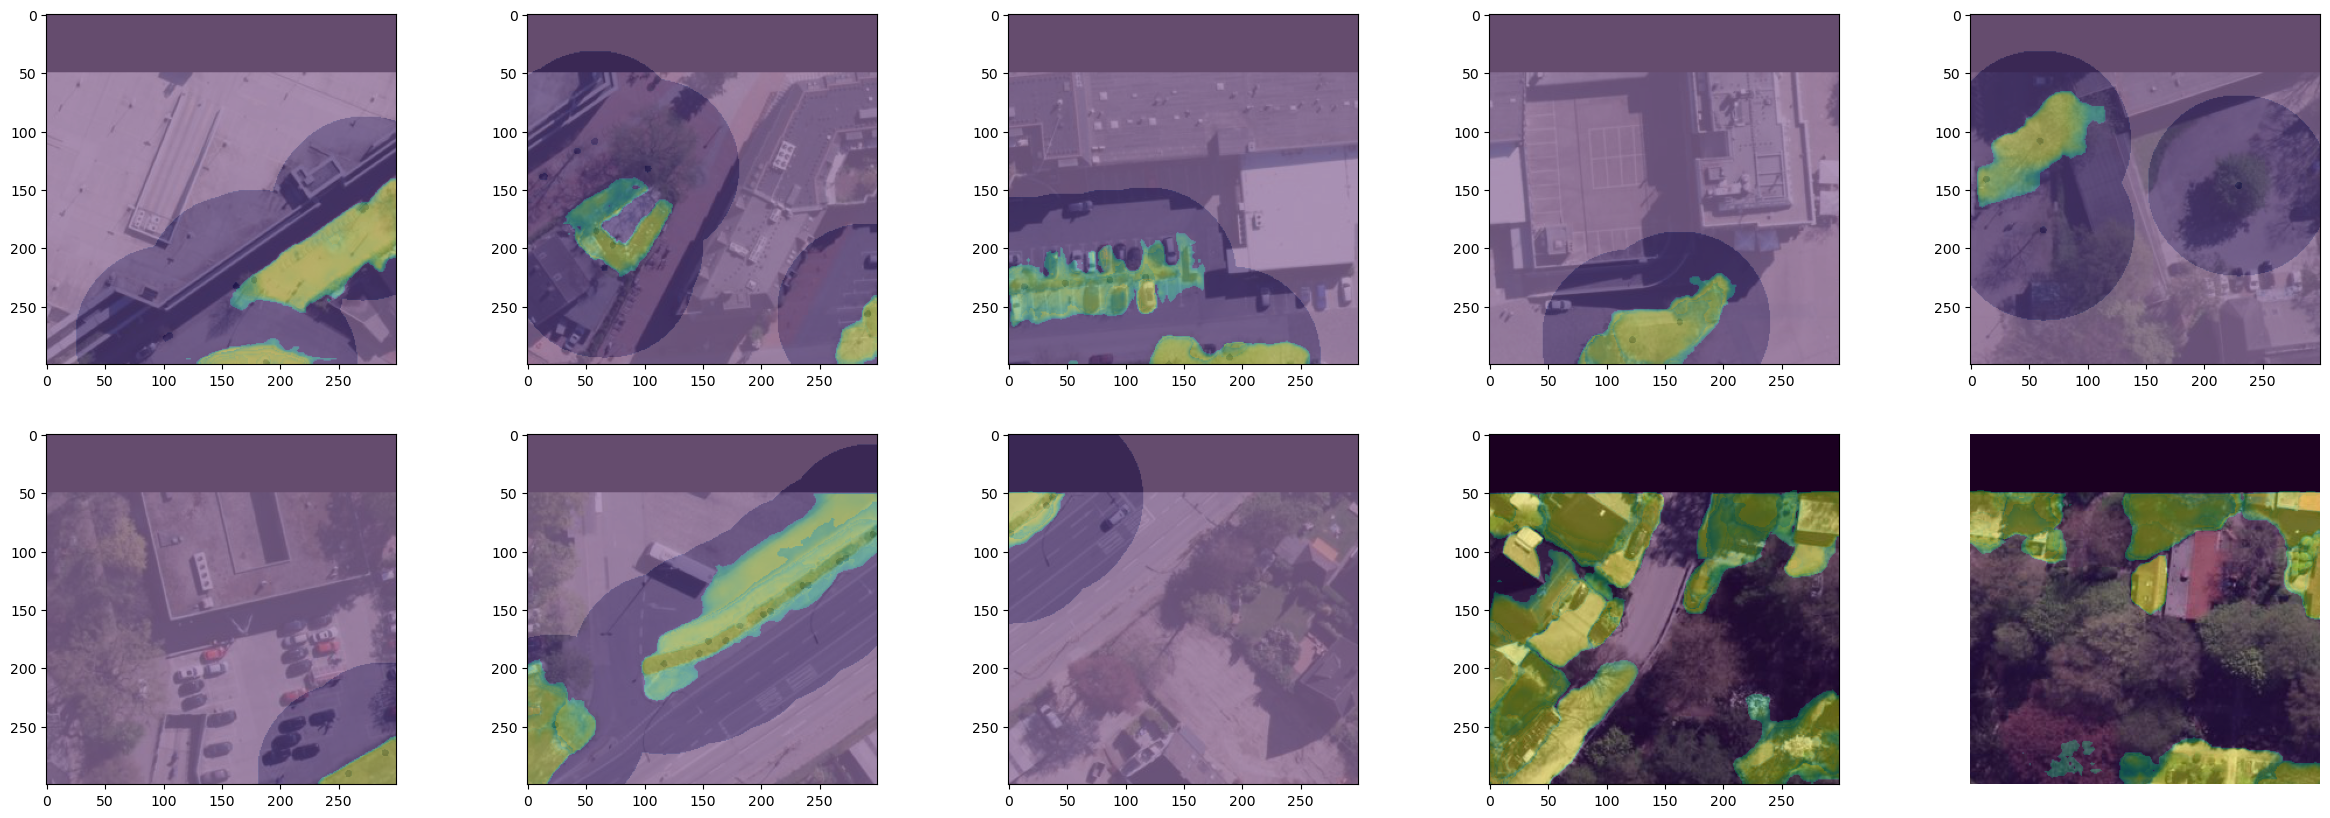

In [43]:
# Load Mask2Former trained on COCO panoptic segmentation dataset
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

mask2former_visulization(data)

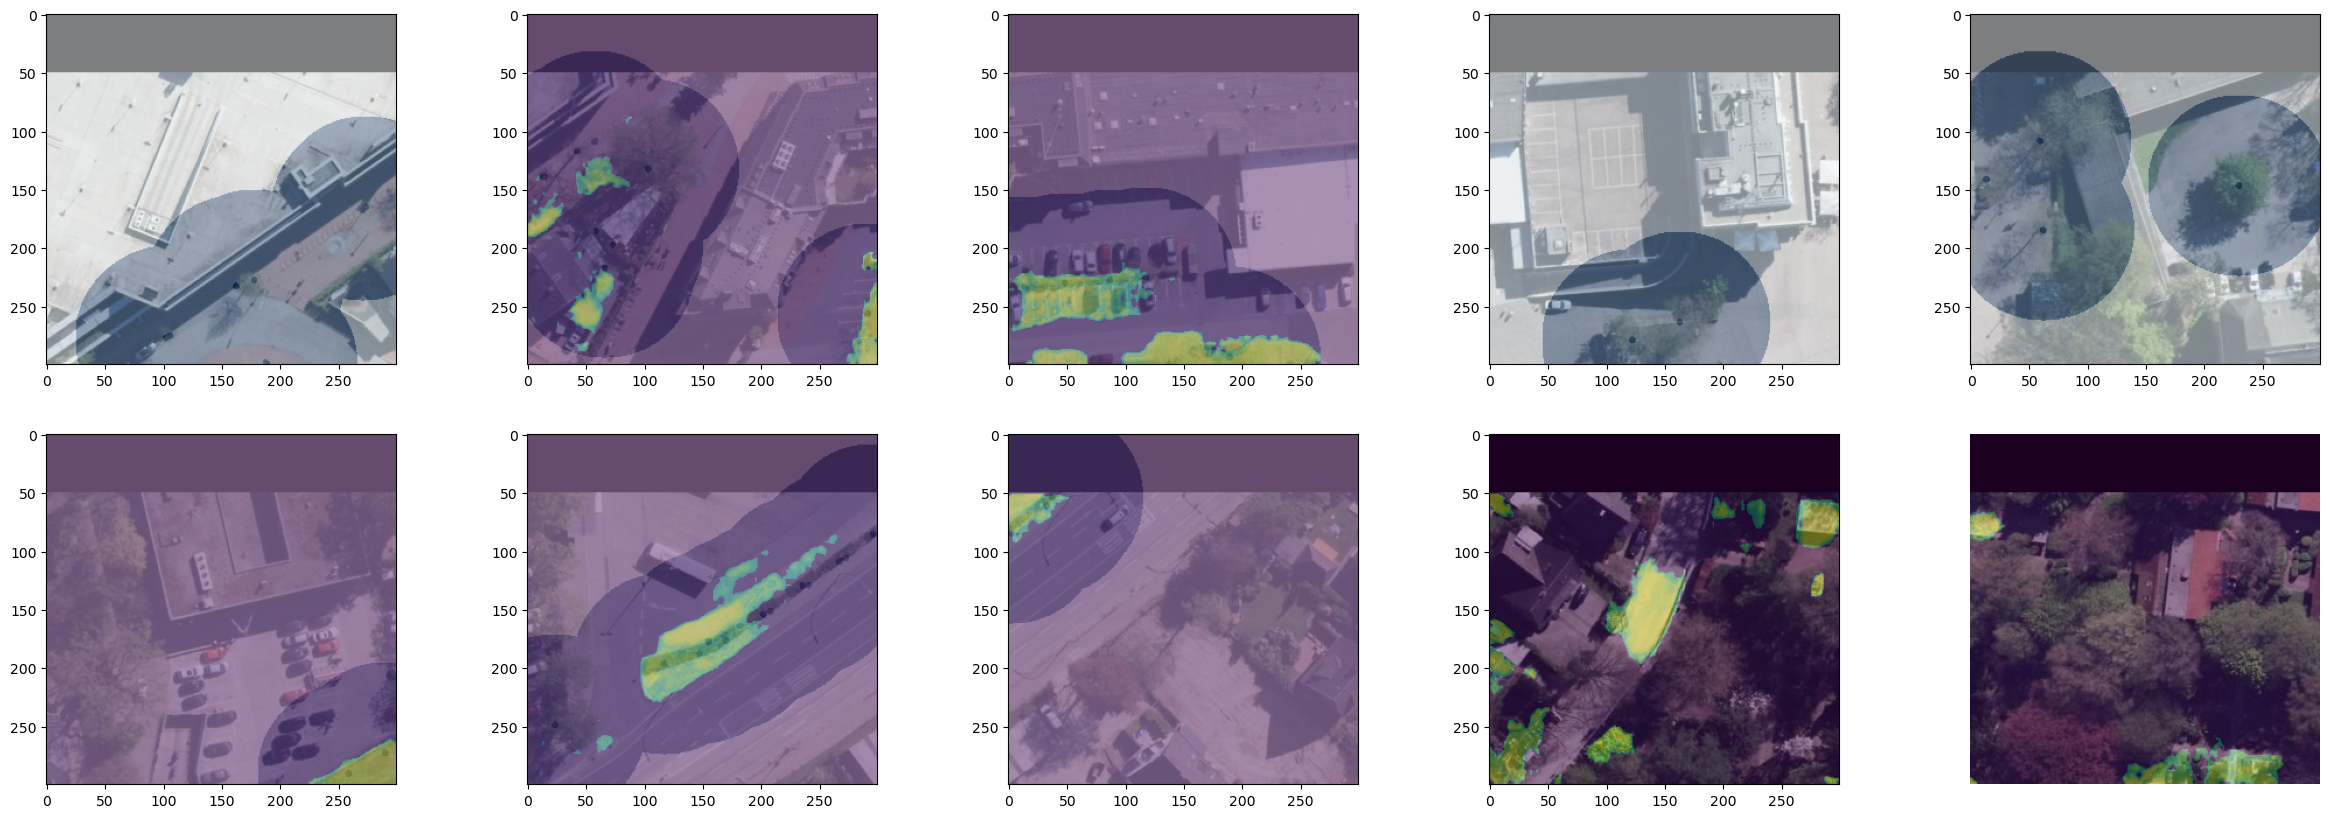

In [33]:
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-cityscapes-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-cityscapes-panoptic"
)

mask2former_visulization(data)

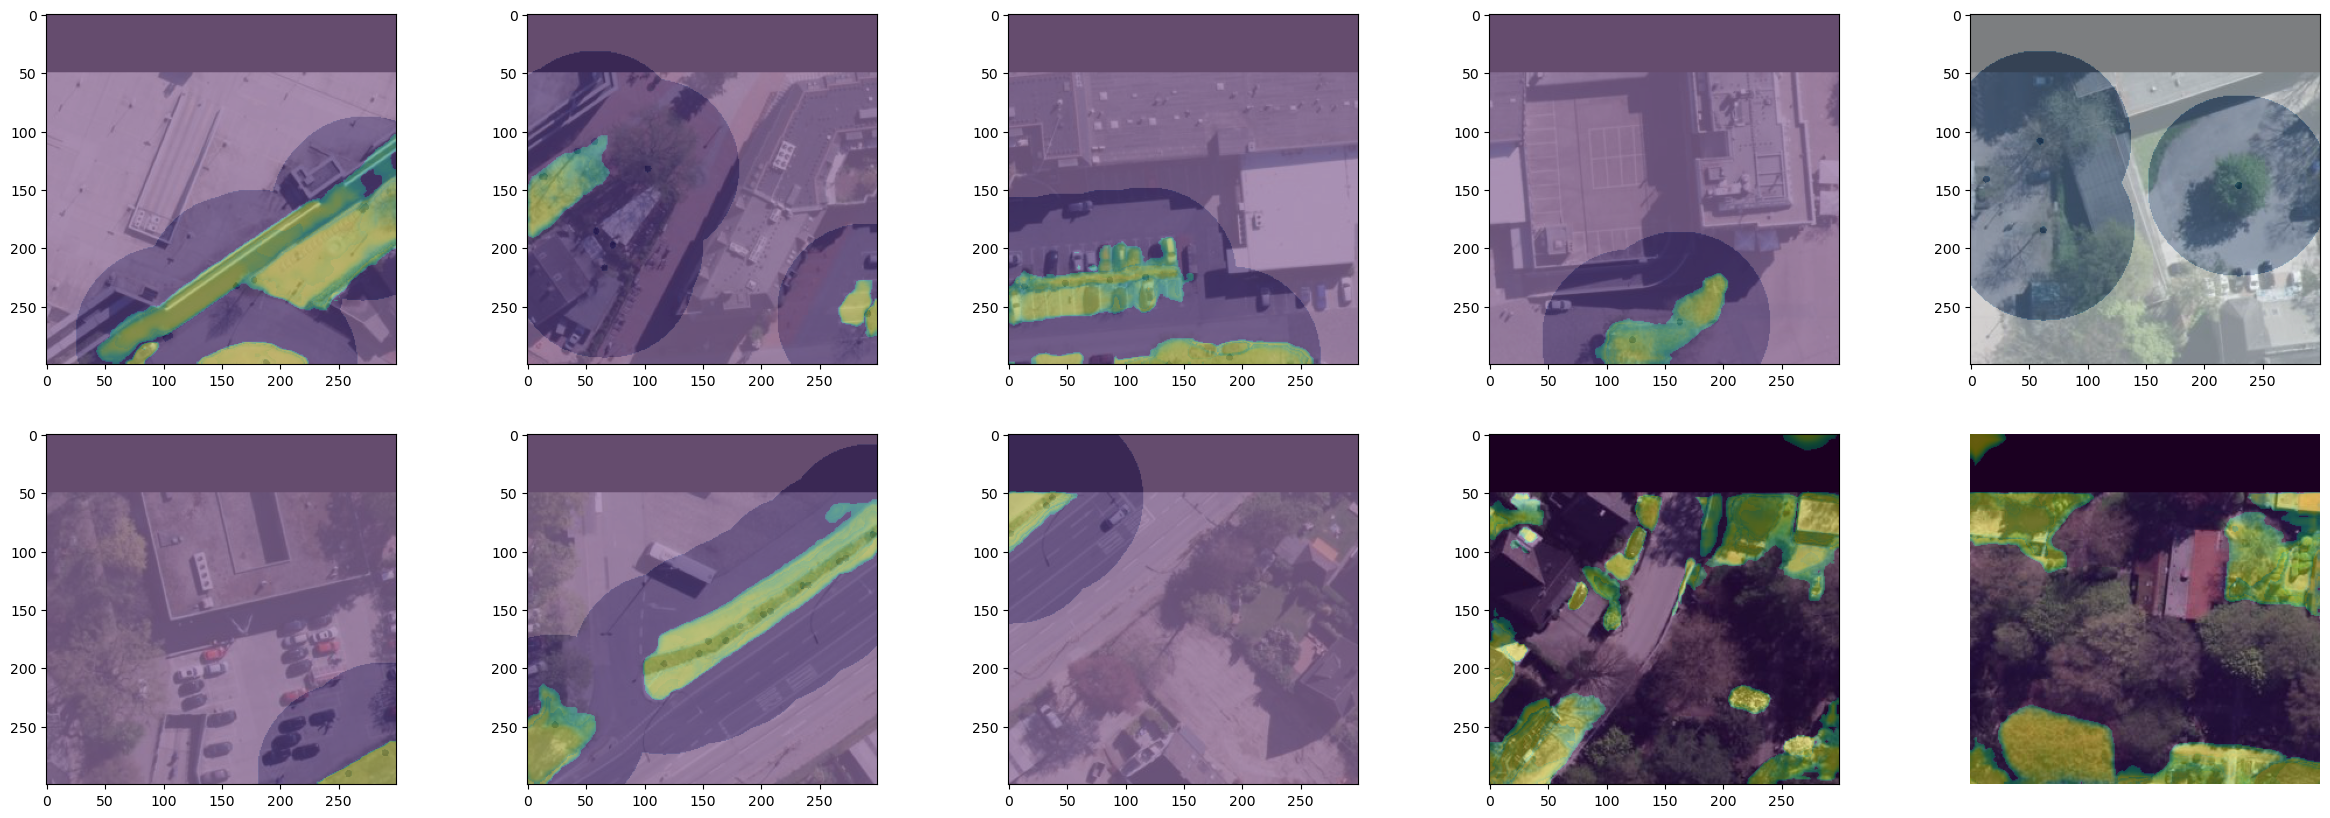

In [36]:
# Use the ADE20K pre-trained model
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-panoptic")


mask2former_visulization(data)

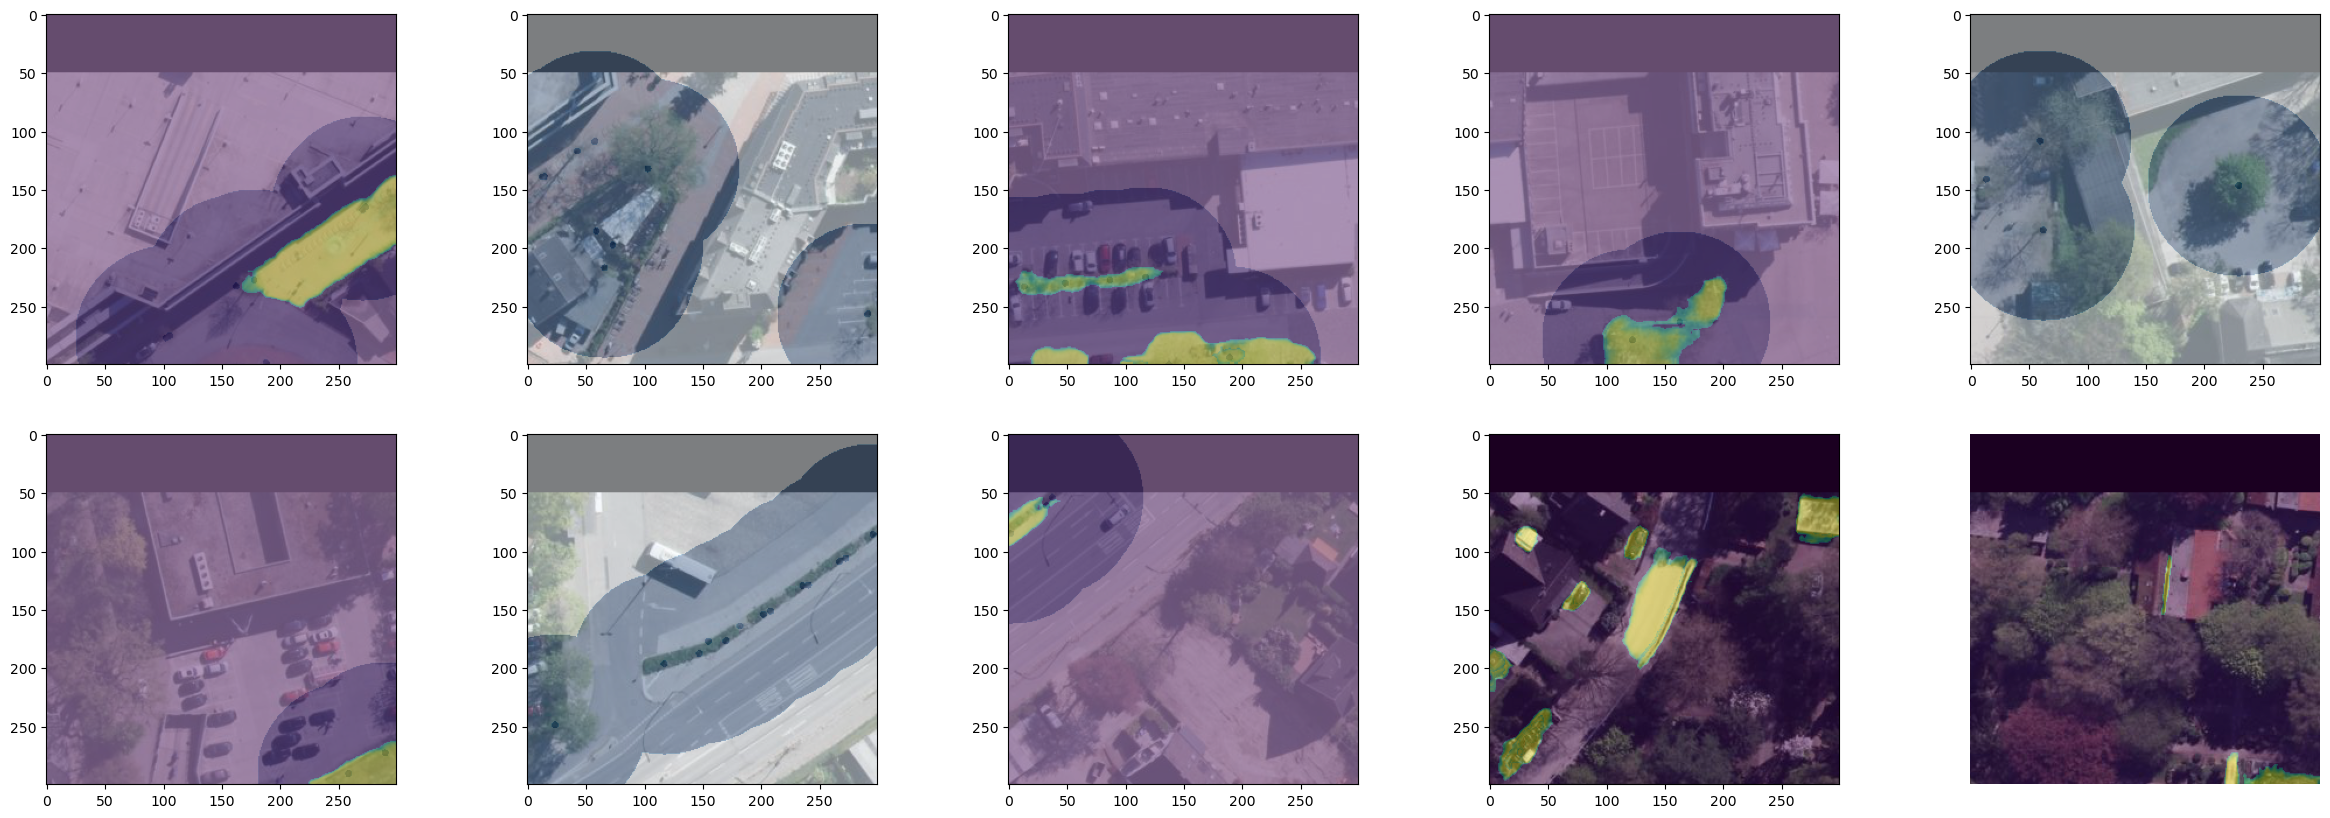

In [39]:
# Use the mapillary-vistas pre-trained model
image_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-panoptic")


mask2former_visulization(data)

In [40]:
from transformers import Dinov2ForImageClassification

# Load the DINOv2 model
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")


def dinov2_visulization(data):
    data1 = data[0:10]
    fig, ax = plt.subplots(2, 5, figsize=(30, 10))
    for i, image_array in enumerate(data1):
        maps = []
        comb_true = False

        image = Image.fromarray((image_array * 255).astype(np.uint8))
        inputs = image_processor(image, return_tensors="pt")

        with torch.no_grad():
            logits = model(**inputs).logits

        class_queries_logits = outputs.class_queries_logits
        masks_queries_logits = outputs.masks_queries_logits

        masks_queries_logits_resized = F.interpolate(masks_queries_logits, size=image.size[::-1], mode='bilinear', align_corners=False)
        masks_queries_logits_sigmoid = torch.sigmoid(masks_queries_logits_resized)


        for mask_index in range(masks_queries_logits_sigmoid.shape[1]):
            mask = masks_queries_logits_sigmoid[0, mask_index, :, :]
            mask[mask < 0.5] = 0

            if np.max(targets[i])==0:
                if torch.sum(mask * non_targets[i].transpose()) == 0:
                    binary_mask = mask.numpy() > 0.4

                    if np.sum(binary_mask) == 0:
                        continue

                    # Calculate the center of mass of the binary mask
                    center_of_mass = ndimage.center_of_mass(binary_mask)
                    
                    indices = np.where(binary_mask)
                    
                    min_y, max_y = np.min(indices[0]), np.max(indices[0])
                    min_x, max_x = np.min(indices[1]), np.max(indices[1])
                    
                    # Check if all values above the threshold are within a 60-pixel radius of the center of mass
                    if (max_y - min_y <= 120) and (max_x - min_x <= 120):
                        maps.append(mask)
                continue

            # Create a binary mask for the target
            binary_target = np.where(targets[i].transpose() == 1, 1, 0).astype(np.uint8)

            # Use a smaller structuring element for faster operation
            selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (150, 150))

            # Perform dilation
            dilated_target = cv2.dilate(binary_target, selem)

            # Check if the entirety of the mask is within the dilated target
            if np.array_equal(mask * dilated_target, mask):
                # Check if any part of the mask overlaps with the target
                if torch.sum(mask * targets[i].transpose()) > 0:
                    # Check if none of the mask overlaps with the non-target
                    if torch.sum(mask * non_targets[i].transpose()) == 0:
                        maps.append(mask)

        if np.shape(maps)[0] != 0:
            combined_mask = combine_masks_average_overlap(maps)
            comb_true = True

        ax[int(i > 4), i%5].imshow(data[i])

        if np.sum(targets[i]) != 0:
            ax[int(i > 4), i%5].imshow(targets[i].transpose(), cmap='Blues', alpha=0.3)
            ax[int(i > 4), i%5].imshow(dilated_target, cmap='Blues', alpha=0.3)
        if comb_true:
            ax[int(i > 4), i%5].imshow(combined_mask, alpha=0.4)  

        plt.axis('off')

OSError: facebook/dinov2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [41]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
import torch

image = data[0]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

print(np.shape(logits))

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

dam, dike, dyke


In [25]:
import torch
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = data[0]

# Load the DINOv2 model and processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base")

# Preprocess the image
inputs = image_processor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get segmentation map
segmentation = outputs.logits.argmax(1).squeeze().cpu().numpy()

# Plot the image and the segmentation map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmentation)
ax[1].set_title("Segmentation Map")
ax[1].axis("off")

plt.show()


AttributeError: 'BaseModelOutputWithPooling' object has no attribute 'logits'

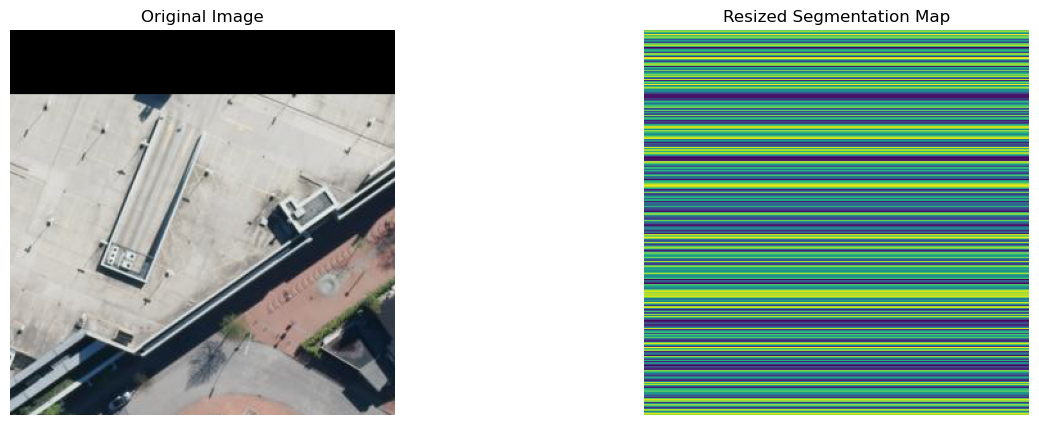

In [34]:
import torch
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = data[0]

# Load the DINOv2 model and processor
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base")

# Preprocess the image
inputs = image_processor(images=image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Get the logits from the last layer
logits = outputs.last_hidden_state

# Assuming the segmentation map is the argmax of the logits along dimension 1
segmentation = logits.argmax(1).squeeze().cpu().numpy()

segmentation_pil = Image.fromarray(segmentation.astype(np.uint8))
# Define the size of the original image
original_image_size = (300, 300)  # (width, height)

# Resize the segmentation map to the size of the original image
segmentation_resized = segmentation_pil.resize(original_image_size, Image.NEAREST)

# Convert the resized segmentation map back to a numpy array
segmentation_resized_np = np.array(segmentation_resized)

# Now you can plot the resized segmentation map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(segmentation_resized_np)
ax[1].set_title("Resized Segmentation Map")
ax[1].axis("off")

plt.show()


In [13]:
import torch
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np

# Function to load the DINO model (using torchvision's implementation)
def load_dino_model():
    from torchvision.models import vit_b_16, ViT_B_16_Weights
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    return model

# Load the image
image_np = data[0]
image = Image.fromarray(image_np)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Load the DINO model
feature_extractor, model = load_dino_model()

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Extract the last hidden states
last_hidden_states = outputs.last_hidden_state

# For demonstration, let's visualize the attention map from the last attention layer
def get_attention_map(model, inputs):
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1].squeeze().cpu().numpy()  # Get the attention weights from the last layer
    return attentions

# Get the attention map
attention_map = get_attention_map(model, inputs)

# Plot the image and the attention map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Use the first attention head for visualization
attn_map = attention_map[0]
ax[1].imshow(attn_map, cmap='hot')
ax[1].set_title("Attention Map")
ax[1].axis("off")

plt.show()


TypeError: cannot unpack non-iterable VisionTransformer object

In [15]:
import torch
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to load the ViT model (using Hugging Face Transformers)
def load_vit_model():
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")
    return feature_extractor, model

# Assuming your image is in a NumPy array called `image_np`
# Example: image_np = np.random.rand(224, 224, 3) * 255
image_np = data[0]  # Replace this with your actual image data
image_np = image_np.astype(np.uint8)

# Convert NumPy array to PIL image
image = Image.fromarray(image_np)

# Load the ViT model
feature_extractor, model = load_vit_model()

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Extract the last hidden states
last_hidden_states = outputs.last_hidden_state

# For demonstration, let's visualize the attention map from the last attention layer
def get_attention_map(model, inputs):
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1].squeeze().cpu().numpy()  # Get the attention weights from the last layer
    return attentions

# Get the attention map
attention_map = get_attention_map(model, inputs)

# Plot the image and the attention map
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Use the first attention head for visualization
attn_map = attention_map[0]
ax[1].imshow(attn_map, cmap='hot')
ax[1].set_title("Attention Map")
ax[1].axis("off")

plt.show()


/var/home/daniel/micromamba/envs/mambaenv/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'NoneType' object has no attribute 'squeeze'

In [23]:
from transformers import AutoImageProcessor, Dinov2Model
import torch

image = data[0]

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
model = Dinov2Model.from_pretrained("facebook/dinov2-base")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

[1, 257, 768]